# Завдання №1
Модифікувати функцію HH для впливу вхідного струму довільної форми (замість постійного рівня вхідного струму) та із застосуванням ODE розрахунку моделі (odeint із scipy.integrate).

Застосувати стимуляцію вхідним струмом, вивести на підграфіки вхідний струм і відповідний йому потенціал нейрона

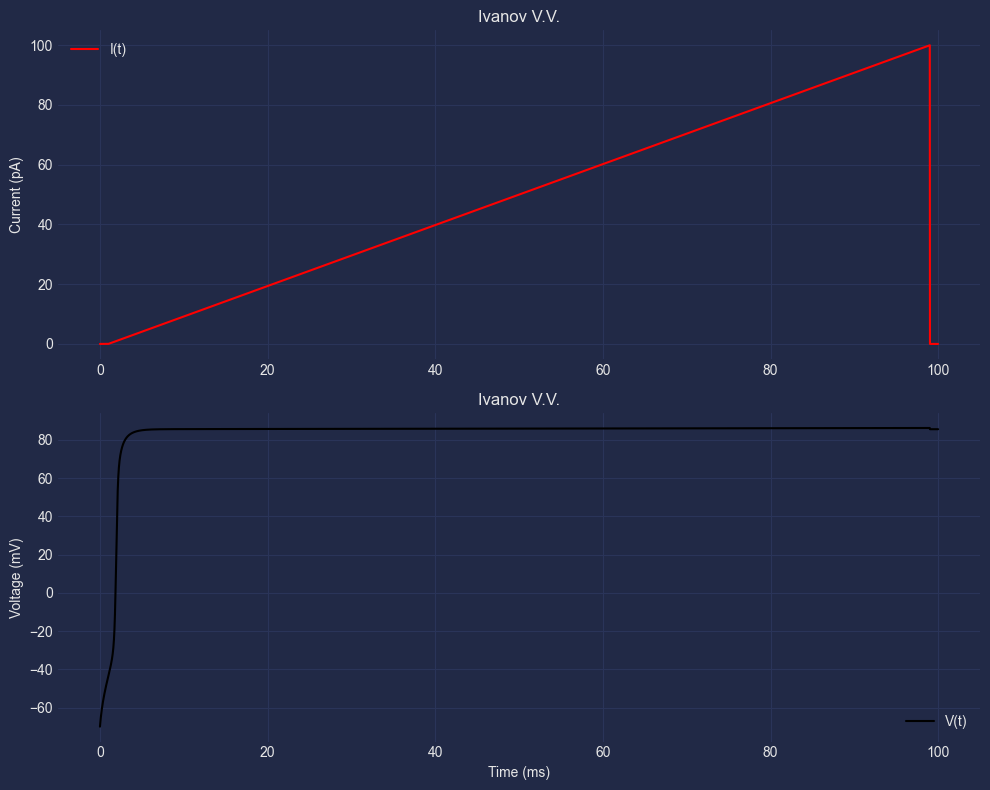

In [96]:
import mplcyberpunk
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use("cyberpunk")

class HodgkinHuxleyModel:
    def __init__(self, T0, dt):
        self.T0 = T0
        self.dt = dt

    def alpha_m(self, V):
        # Функція для alpha_m (зворотній трикутник)
        return 1.0 / (1 + np.exp(-(V + 30) / 5))

    def beta_m(self, V):
        # Функція для beta_m (зворотній трикутник)
        return 1.0 / (1 + np.exp((V + 30) / 5))

    def alpha_h(self, V):
        # Функція для alpha_h (зворотній трикутник)
        return 1.0 / (1 + np.exp(-(V + 50) / 10))

    def beta_h(self, V):
        # Функція для beta_h (зворотній трикутник)
        return 1.0 / (1 + np.exp((V + 50) / 10))

    def alpha_n(self, V):
        # Функція для alpha_n (зворотній трикутник)
        return 1.0 / (1 + np.exp(-(V + 40) / 5))

    def beta_n(self, V):
        # Функція для beta_n (зворотній трикутник)
        return 1.0 / (1 + np.exp((V + 40) / 5))

    def I_func(self, t):
        if 1 <= t <= (self.T0 - 1):
            return 100 * (t - 1) / (self.T0 - 2)
        return 0

    def HH_model(self, Y, t):
        V, m, h, n = Y
        I = self.I_func(t)
        dV = I - 120 * m ** 3 * h * (V - 115) - 36 * n ** 4 * (V + 12) - 0.3 * (V - 10.6)
        dm = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
        dh = self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
        dn = self.alpha_n(V) * (1 - n) - self.beta_n(V) * n
        return [dV, dm, dh, dn]

    def simulate(self):
        time = np.arange(0, self.T0, self.dt)
        init_conditions = [-70, 0.05, 0.54, 0.34]
        result = odeint(self.HH_model, init_conditions, time)
        V, m, h, n = result.T
        return V, m, h, n, time

    def plot(self, V, time):
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        plt.plot(time, [self.I_func(t) for t in time], 'r', label="I(t)")
        plt.ylabel('Current (pA)')
        plt.title("Ivanov V.V.")
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(time, V, 'k', label="V(t)")
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
        plt.title("Ivanov V.V.")
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    T0 = 100
    dt = 0.01
    model = HodgkinHuxleyModel(T0, dt)
    V, m, h, n, time = model.simulate()
    model.plot(V, time)


# Завдання №2
Вивести на графік ефект "все-або-нічого", оцінити різницю амплітуд подразнення.

Тривалість симуляції 10 мс. Тривалість подразнення нейрона від 0.05 до 0.5 мс, конкретне значення в таблиці.

Peak Amplitude for Stimulus Duration 1: 85.54432681860092 mV
Peak Amplitude for Stimulus Duration 2: 85.54432976612502 mV
Мінімальний вхідний струм, який викликає потенціал дії: 0 пA


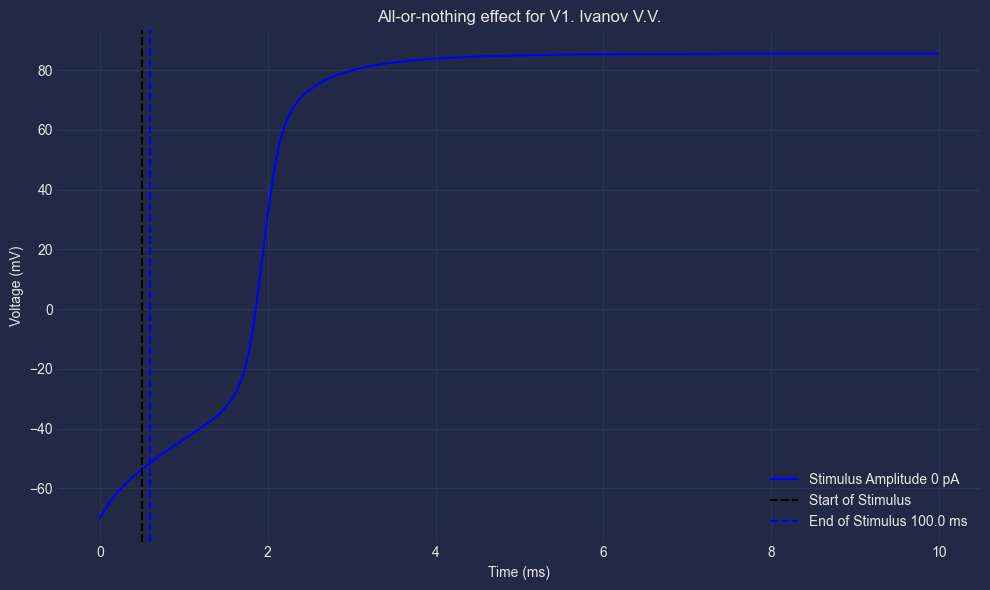

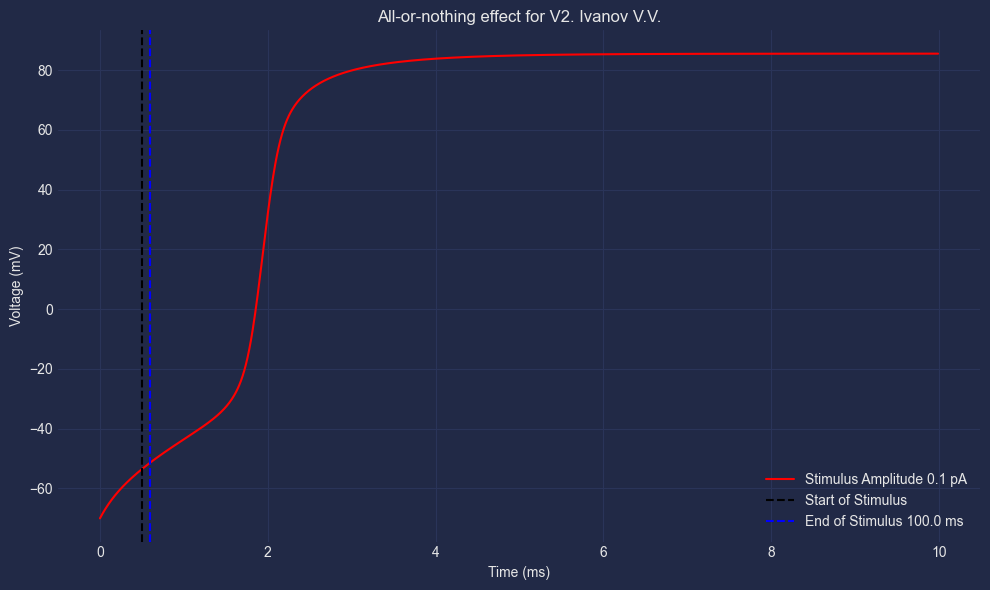

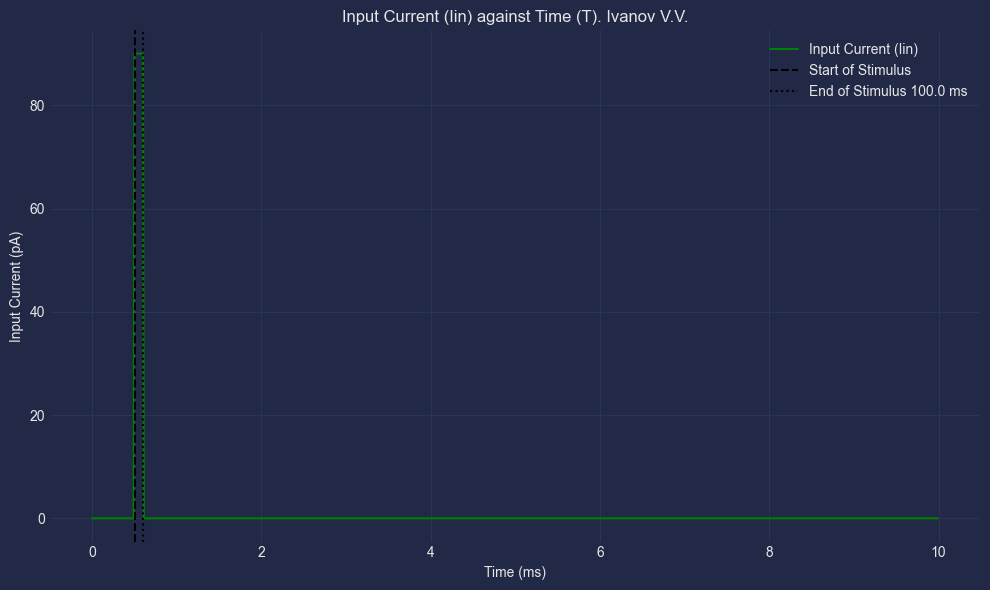

In [97]:
def all_or_nothing_simulation(T0, dt, stimulus_duration):
    model = HodgkinHuxleyModel(T0, dt)

    # Simulate without stimulus
    model.I_func = lambda t: 0
    V_rest, m, h, n, time = model.simulate()

    # Find the minimum current that does not cause an action potential
    min_current = find_min_current_for_AP(T0, dt, stimulus_duration)

    # Simulate with the first stimulus (0.1 ms duration, min_current amplitude)
    model.I_func = lambda t: min_current if (0.5 <= t <= 0.5 + stimulus_duration) else 0
    V1, m, h, n, time = model.simulate()
    peak_amplitude1 = max(V1)  # Peak amplitude of the first response

    # Simulate with the second stimulus (0.1 ms duration, slightly larger amplitude)
    model.I_func = lambda t: min_current + 0.1 if (0.5 <= t <= 0.5 + stimulus_duration) else 0
    V2, m, h, n, time = model.simulate()
    peak_amplitude2 = max(V2)  # Peak amplitude of the second response

    return V_rest, V1, V2, time, peak_amplitude1, peak_amplitude2


def plot_all_or_nothing(V1, V2, time, stimulus_duration, min_current):
    # Plot for V1
    plt.figure(figsize=(10, 6))
    plt.plot(time, V1, 'b', label=f"Stimulus Amplitude {round(min_current, 2)} pA")
    plt.axvline(x=0.5, color='k', linestyle='--', label='Start of Stimulus')
    plt.axvline(x=0.5 + stimulus_duration, color='b', linestyle='--', label=f'End of Stimulus {stimulus_duration*1000} ms')
    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (ms)')
    plt.title("All-or-nothing effect for V1. Ivanov V.V.")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Plot for V2
    plt.figure(figsize=(10, 6))
    plt.plot(time, V2, 'r', label=f"Stimulus Amplitude {round(min_current + 0.1, 2)} pA")
    plt.axvline(x=0.5, color='k', linestyle='--', label='Start of Stimulus')
    plt.axvline(x=0.5 + stimulus_duration, color='b', linestyle='--', label=f'End of Stimulus {stimulus_duration*1000} ms')
    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (ms)')
    plt.title("All-or-nothing effect for V2. Ivanov V.V.")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def find_min_current_for_AP(T0, dt, stimulus_duration, threshold=-20):
    model = HodgkinHuxleyModel(T0, dt)

    min_current = 0
    max_current = 100
    tol = 0.1

    while max_current - min_current > tol:
        current = (min_current + max_current) / 2
        model.I_func = lambda t: current if 0.5 <= t <= 0.5 + stimulus_duration else 0
        V, m, h, n, time = model.simulate()
        if max(V) > threshold:
            max_current = current
        else:
            min_current = current

    return min_current


def plot_input_current(T0, dt, stimulus_duration, max_current):
    # Defining the time array
    time = np.arange(0, T0, dt)

    # Define the input current function
    Iin_func = lambda t: max_current if (0.5 <= t <= 0.5 + stimulus_duration) else 0
    Iin = [Iin_func(t) for t in time]

    # Plotting the input current against time
    plt.figure(figsize=(10, 6))
    plt.plot(time, Iin, 'g', label=f"Input Current (Iin)")
    plt.axvline(x=0.5, color='k', linestyle='--', label='Start of Stimulus')
    plt.axvline(x=0.5 + stimulus_duration, color='k', linestyle=':', label=f'End of Stimulus {stimulus_duration*1000} ms')
    plt.ylabel('Input Current (pA)')
    plt.xlabel('Time (ms)')
    plt.title("Input Current (Iin) against Time (T). Ivanov V.V.")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    T0 = 10
    dt = 0.01
    stimulus_duration = 0.1  # Стимул 0.1 мс
    V_rest, V1, V2, time, peak_amplitude1, peak_amplitude2 = all_or_nothing_simulation(T0, dt, stimulus_duration)
    min_current = find_min_current_for_AP(T0, dt, stimulus_duration)
    print(f"Peak Amplitude for Stimulus Duration 1: {peak_amplitude1} mV")
    print(f"Peak Amplitude for Stimulus Duration 2: {peak_amplitude2} mV")
    print(f"Мінімальний вхідний струм, який викликає потенціал дії: {min_current} пA")

    plot_all_or_nothing(V1, V2, time, stimulus_duration, min_current)
    max_current_value = 90  # This value can be adjusted based on the actual simulation
    # Calling the function to plot the graph
    plot_input_current(T0, dt, stimulus_duration, max_current_value)